In [1]:
# Imports
# turn off automated parallelization:
import os
os.environ["OMP_NUM_THREADS"] = "1"
from scipy.io import loadmat
import numpy as np
import matplotlib.pyplot as plt
from pandas import read_csv
from glob import glob
import re
from obspy import UTCDateTime
from scipy.optimize import minimize
import multiprocessing
import emcee
import corner
from math import pi

## Function definitions 

In [56]:
# all the function definitions here

# very basic model of dvv
def model_dvv_0(params, lake_level, rain, temperature):  # potentially add further parameters and input vectors, like wind speed, ...

    # parameters:
    a, b, c, d, e, f = params

    if b > len(lake_level):
        return(np.ones(len(lake_level)) + np.nan)
    
    if b < 0:
        return(np.ones(len(lake_level)) + np.nan)

    if d > len(lake_level):
        return(np.ones(len(lake_level)) + np.nan)
    
    if d < 0:
        return(np.ones(len(lake_level)) + np.nan)

    if f > len(lake_level):
        return(np.ones(len(lake_level)) + np.nan)
    
    if f < 0:
        return(np.ones(len(lake_level)) + np.nan)
    

    # lake level: time shifted
    # sensitivity, shift: a, b
    b = int(b)
    lake_level = np.roll(lake_level, b)
    lake_level[0:b] = lake_level[b]
    
    # rain: cumulative and time shifted
    # sensitivity, shift: c, d
    r = np.cumsum(rain)
    d = int(d)
    r = np.roll(r, d)
    r[0: d] = r[d]

    # temperature: time shifted
    # sensitivity, shift: e, f
    f = int(f)
    temp = np.roll(temperature, f)
    temp[0: f] = temp[f]

    
    dvv_synth = a * lake_level + c * r + e * temp
    return(dvv_synth)


def model_dvv_1(params, lake_level):  # only lake level, for testing purposes

    # parameters:
    a, b = params
    
    if b > len(lake_level):
        return(np.ones(len(lake_level)) + np.nan)
    
    if b < 0:
        return(np.ones(len(lake_level)) + np.nan)
    
        
    # lake level: time shifted
    # sensitivity, shift: a, b
    b = int(b)
    ll = lake_level.copy()
    ll = np.roll(ll, b)
    ll[0:b] = ll[b]
    
    
    dvv_synth = a * ll
    return(dvv_synth)


def data_model_misfit(data, model):
    mf = 0
    for dd in data:
        mf += 0.5 * np.sum((dd - model)**2)
    return mf / len(data) 

# uniform PRIOR for emcee
def uniform_prior_for_emcee(params, bounds):
    for i, p in enumerate(params):
        if p < bounds[i][0]:
            return(-np.inf)
        if p > bounds[i][1]:
            return(-np.inf)
    return(0.0)

# log. LIKELIHOOD for emcee
def log_likelihood_for_emcee(params, ind_vars, data, data_err=None, func=lambda x: x):
    ll = 0.0

        
    # get the synthetics for these parameters
    synth = function(params, *ind_vars)
    
    # data could be several dimensions
    data = np.array(data)
    if np.ndim(data) == 1:
        data = np.array(data, ndmin=2)
        if data_err is None:
            data_err = np.ones(data.shape)
        else:
            data_err = np.array(data_err, ndmin=2)

    for ixd, d in enumerate(data):

        sigma2 = data_err[ixd] ** 2
        res = synth - d
        # print(np.abs(res).max())
        ll += -0.5 * np.sum(res ** 2 / sigma2) - np.sum(np.log(np.sqrt(2. * pi * sigma2)))

    return ll


# log. probability for emcee
def log_probability_for_emcee(params, ind_vars, bounds, data, cov, func):

    prior = uniform_prior_for_emcee(params, bounds)
    llh = log_likelihood_for_emcee(params, ind_vars, data, cov, func)
    #print("Prior, ", prior)
    #print("loglikelihood, ", llh)
    if not np.isfinite(prior):
        return(-np.inf)
    else:
        return(llh + prior)




# Fixed model parameters and starting values

## Input related to data

In [75]:
# All the inputs here +++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

#input_sn = [15222, 16192, 16295, 16320, 16820, 18667]  # southwest end serial numbers
# input_sn = [14593, 15716, 16037, 16691, 16944, 18324] # la barme
input_sn = [14800, 15048, 15318, 15639, 18069, 18468] # center
input_files = [f"data/dvv/stretch_causal_3_windowl_500_CC_matrix_DIX-{sn}_0.25-0.5Hz_nowhite_4.0hours.mat" for sn in input_sn]

# 30 time windows:
# t_dvv = np.arange(227.6, 255. + 0.16, 0.23)
# 3 time windows
t_dvv = np.arange(227.2, 255. + 0.1, 0.19)
t_dvv = [UTCDateTime(f"2024,{int(tdv)}") + (tdv - int(tdv)) * 86400. for tdv in t_dvv]


meteo = "data/meteo/gd_dix_meteo_lac.csv"
t0_meteo = UTCDateTime("2024,226").timestamp
dt_meteo = 0.5 * 86400.

# ++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++++

## Loading data

In [76]:
all_dvv = []
all_cc = []
for input_file in input_files:
    try:
        dvv_data = loadmat(input_file)
        cc = dvv_data["cc"]
        dvv = dvv_data["eps"]
        all_dvv.append(dvv[:, 0])
        all_cc.append(cc[:, 0])
    except Exception as e:
        print(e)
        continue

df_meteo = read_csv(meteo)
t_meteo = np.linspace(t0_meteo, t0_meteo + dt_meteo * (len(df_meteo) - 1), len(df_meteo))
lake_volume = [float(re.sub("'", "", v)) for v in df_meteo["volume"].values]
lake_level = np.array([float(re.sub("'", "", v)) for v in df_meteo["msm"].values])
rain = df_meteo["rainfall"]
temperature = df_meteo["temp"]

# interpolate all meteo params to time steps of data
lake_level = np.interp(t_dvv, t_meteo, lake_level - lake_level.mean())  # in m
rain = np.interp(t_dvv, t_meteo, rain)
temperature = np.interp(t_dvv, t_meteo, temperature)


[Errno 2] No such file or directory: 'data/dvv/stretch_causal_3_windowl_500_CC_matrix_DIX-15639_0.25-0.5Hz_nowhite_4.0hours.mat'


<BarContainer object of 147 artists>

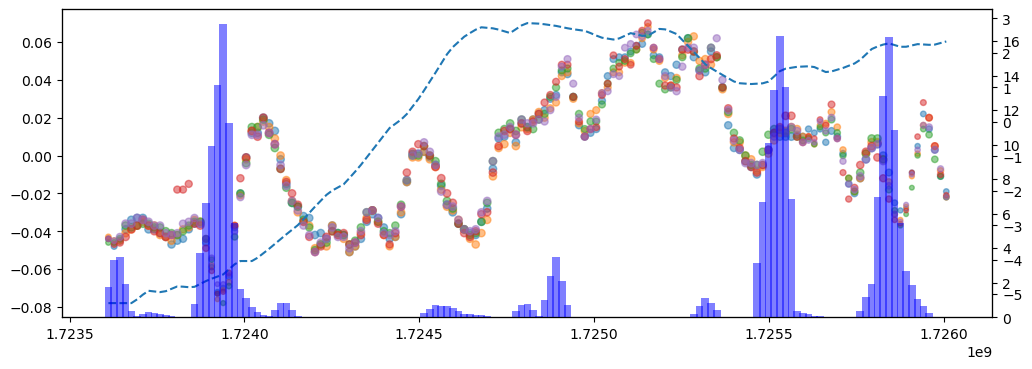

In [77]:
ax1 = plt.figure(figsize=(12, 4)).add_subplot(111)

for dvv, cc in zip(all_dvv, all_cc): 
    plt.scatter(t_dvv, dvv, marker="o", s=30.**cc, alpha=0.5)

ax2 = ax1.twinx()
ax2.plot(t_dvv, lake_level, "--")

ax3 = ax1.twinx()
ax3.bar(t_dvv, rain, width=86400//4, color="b", alpha=0.5)


## Curve fit

0.0917062538989077
[ 4.22409141e-03  6.09593362e+01 -5.89941298e-06  4.83352837e+00
  8.07360950e-04  1.36088197e+00]


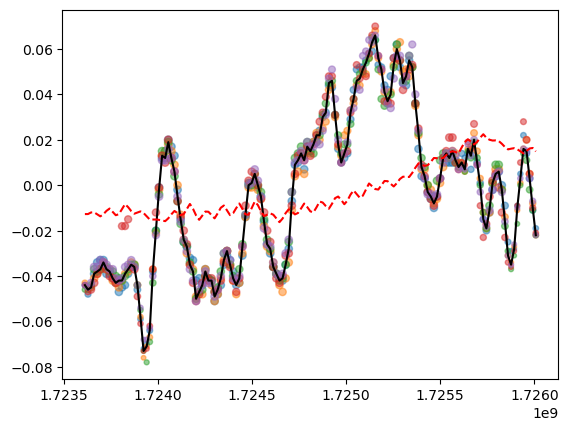

In [78]:
# initialise params by a first curve fit

def function_to_evaluate(params, args):
    data, lake_level, rain, temperature = args
    model = model_dvv_0(params, lake_level, rain, temperature)
    
    #data, lake_level = args
    #model = model_dvv_1(params, lake_level)
    
    return(data_model_misfit(data, model))

dvv_med = np.nanmedian(np.array(all_dvv), axis=0)
# replace data that is nan by the median of the others:
for dvv in all_dvv:
    dvv[np.isnan(dvv)] = dvv_med[np.isnan(dvv)]

x0 = [0.1, 23,-1.e-2, 3, 1e-2, 3]
result = minimize(function_to_evaluate, x0, args=[[dvv_med], lake_level, rain, temperature], method="Nelder-Mead")
# result = minimize(function_to_evaluate, x0, args=[[dvv_med], lake_level], method="Nelder-Mead")

for dvv, cc in zip(all_dvv, all_cc): 
   plt.scatter(t_dvv, dvv, marker="o", s=30.**cc, alpha=0.5)
plt.plot(t_dvv, dvv_med, "k")

synth = model_dvv_0(result.x, lake_level, rain, temperature)
print(data_model_misfit(dvv_med, synth))
plt.plot(t_dvv, synth, "r--")
print(result.x)
# synth1 = model_dvv_0([0.01, 25, 0, 0, 0, 0], lake_level, rain, temperature)
# print(data_model_misfit(dvv_med, synth1))
# plt.plot(t_dvv, synth1, "g--")

plt.show()

## Input related to the MCMC model

In [83]:
output_dir = "test"
# chains to run
n_initializations = 12
n_multiprocess = 4
n_iterations = 20000
n_burnin = 5000
max_iterations = 100_000

# which function to use? adapt bounds, parameters etc to the model that is being used
function = model_dvv_0

# bounds
# bounds on the amplitude of the influence of the lakelevel
bounds_lakelevel = [-2, 2]
# how many time windows can the shift be?
bounds_lakelevelshift = [0, 60]
bounds_rain = [-2, 2]
bounds_rainshift = [0, 60]
bounds_temperature = [-2, 2]
bounds_tempshift = [0, 60]

bounds = [bounds_lakelevel, bounds_lakelevelshift, bounds_rain, bounds_rainshift, bounds_temperature, bounds_tempshift]
# bounds = [bounds_lakelevel, bounds_lakelevelshift]

# independent variables:
independent_variables = [lake_level, rain, temperature]
# independent_variables = [lake_level]

# dvv_error
dvv_error = np.ones(dvv_qc.shape) * 0.001



In [84]:
# MCMC inversion to improve the fit
if not os.path.exists(output_dir):
    os.makedirs(output_dir)


# initial position:
init_pos = result.x

# data
dvv_qc = np.array(all_dvv)

# log_probability_for_emcee(params, ind_vars, bounds, data, cov)
# get the initial position from the max. likeligood model and perturb by small random nrs
print("initial values: ", init_pos)

# add quite small perturbations to the starting model
perturb_initial_values = 0.01 * np.random.randn(n_initializations, len(init_pos)) + 1.0
position = np.array([init_pos]*n_initializations) * perturb_initial_values + 0.01 * (perturb_initial_values - 1.)

# initialize the walkers of the MCMC
nwalkers, ndim = (n_initializations, len(init_pos))

with multiprocessing.Pool(n_multiprocess) as pool:
    # Initialize the sampler
    # here you can edit the types of moves etc.
    ind_vars = independent_variables
    cov = dvv_error
    data = dvv_qc
    sampler = emcee.EnsembleSampler(nwalkers, ndim, log_probability_for_emcee,
                                    moves=[(emcee.moves.StretchMove(a=2.0), 0.5),
                                            (emcee.moves.DESnookerMove(), 0.5)],
                                    args=(ind_vars, bounds, data, cov, function),
                                    pool=pool)
    iterations_performed = 0
    have_tau = False
    while True:
        try:
            position = sampler.run_mcmc(position, n_iterations, progress=True, skip_initial_state_check=True)
            iterations_performed += n_iterations
        except ValueError:  # badly conditioned starting point
            position = sampler.get_last_sample()
            position.coords += np.random.randn(n_initializations, len(init_pos)) *\
                               np.array(init_perturbation[0: len(init_pos)])

        try:
            tau = sampler.get_autocorr_time(discard=n_burnin)
        except Exception as e:
            print(e)
            if iterations_performed < max_iterations:
                print("Apparently no convergence yet, adding another {} samples.".format(n_iterations))
                continue
            else:
                print("No convergence despite performing maximum number of iterations. Giving up.")
                break
            
        print(tau)
        if not np.any(np.isnan(tau)):
            foname = output_dir + "/tau.txt"
            with open(foname, "w") as fh:
                for ttau in tau:
                    fh.write(f"{ttau}")
            thin = int(np.max(tau)) // 2
            print("Tau could be estimated, tau: ", np.max(tau))
            have_tau = True
            break
        else:
            if iterations_performed < max_iterations:
                print("Apparently no convergence yet, adding another {} samples.".format(n_iterations))
            else:
                print("No convergence despite performing maximum number of iterations. Giving up.")
                break


if not have_tau:
    thin = 2

# get and save the samples
all_samples_temp = sampler.get_chain(discard=n_burnin)
# save the "clean" ensemble: Post burn-in, flat, decimated by 1/2 * autocorrelation time.
flat_samples = sampler.get_chain(flat=True, discard=n_burnin, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=n_burnin, flat=True, thin=thin)

foname = output_dir + "/probability_{}{}.npy".format("test_inversion", {True: "", False: "_noconvergence"}[have_tau])
np.save(foname, log_prob_samples)
foname = (output_dir + "/samples_{}{}.npy".format("test_inversion", {True: "", False: "_noconvergence"}[have_tau]))
np.save(foname, flat_samples)

# get the median and percentile models and save
mcmcout = []
for ixp in range(ndim):
    mcmcout.append(np.percentile(flat_samples[:, ixp], [16, 50, 84]))
mcmcout = np.array(mcmcout)
foname = (output_dir + "/percs_{}{}.npy".format("test_inversion", {True: "", False: "_noconvergence"}[have_tau]))
np.save(foname, mcmcout)

# Plot the chains
fig, axes = plt.subplots(ndim, figsize=(10, 2*ndim), sharex=True)
labels = ["a",  "b",  "c", "d", "e", "f"]
for ixparam in range(ndim):
    ax = axes[ixparam]
    ax.plot(all_samples_temp[:, :, ixparam], "k", alpha=0.3)
    ax.set_xlim(0, len(all_samples_temp))
    ax.set_ylabel(labels[ixparam])
    ax.yaxis.set_label_coords(-0.1, 0.5)
axes[-1].set_xlabel("Step number")
foname = (output_dir + "/MCMC_chains_{}{}.png".format("test_inversion", {True: "", False: "_noconvergence"}[have_tau]))
fig.savefig(foname)
plt.close()


# Create a corner plot and save
flat_samples = sampler.get_chain(flat=True, discard=n_burnin, thin=thin)
log_prob_samples = sampler.get_log_prob(discard=n_burnin, flat=True, thin=thin)
print(flat_samples.shape)
print(log_prob_samples.shape)
print(log_prob_samples)
if flat_samples.shape[0] > 50:
    samples_probs = np.concatenate((flat_samples, log_prob_samples[:, None]), axis=1)
    print(samples_probs.shape)

    labels += ["log prob"]
    fig = corner.corner(
        samples_probs, labels=labels
    );
    foname = (output_dir + "/MCMC_{}{}.png".format("test_inversion", {True: "", False: "_noconvergence"}[have_tau]))
    fig.savefig(foname)
    plt.close()

initial values:  [ 4.22409141e-03  6.09593362e+01 -5.89941298e-06  4.83352837e+00
  8.07360950e-04  1.36088197e+00]


100%|████████████████████████████████████| 20000/20000 [00:53<00:00, 373.89it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 6 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 300;
tau: [1426.11809972 1181.5372406  1917.82586599  740.34262622 1686.37760709
  471.3527238 ]
Apparently no convergence yet, adding another 20000 samples.


100%|████████████████████████████████████| 20000/20000 [00:54<00:00, 366.55it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 5 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 700;
tau: [3488.99311095 1134.01820115 2116.71617279  951.37226057 1946.94813986
  514.22694856]
Apparently no convergence yet, adding another 20000 samples.


100%|████████████████████████████████████| 20000/20000 [00:54<00:00, 369.78it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 4 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1100;
tau: [5402.67409154 1100.72751054 2090.19402908  908.33776414 2113.89053497
  504.55458998]
Apparently no convergence yet, adding another 20000 samples.


100%|████████████████████████████████████| 20000/20000 [00:53<00:00, 373.15it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1500;
tau: [6643.62932441 1052.01533669 2075.54502365  810.7651384  2191.1211146
  467.58910599]
Apparently no convergence yet, adding another 20000 samples.


100%|████████████████████████████████████| 20000/20000 [00:51<00:00, 384.79it/s]


The chain is shorter than 50 times the integrated autocorrelation time for 3 parameter(s). Use this estimate with caution and run a longer chain!
N/50 = 1900;
tau: [7463.65167298  998.97849103 2066.06359269  741.78674802 2235.26943673
  424.12793743]
No convergence despite performing maximum number of iterations. Giving up.
(570000, 6)
(570000,)
[-125468.92315242 -125480.83633872 -125477.97893284 ... -120521.21125139
 -120521.4824446  -120521.5710153 ]
(570000, 7)


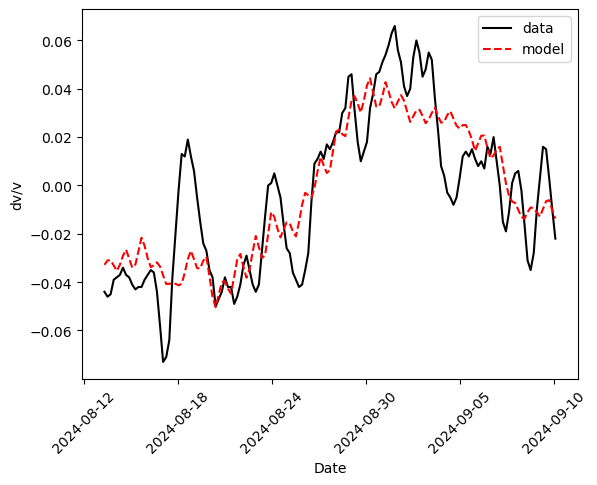

In [85]:
plt.plot(t_dvv, dvv_med, "k")
plt.plot(t_dvv, model_dvv_0(mcmcout[:, 1], lake_level, rain, temperature), "r--")

plt.xlabel("Date")
xt = plt.xticks()

xtn = []
for xtt in xt[0]:
    xtn.append(UTCDateTime(xtt).strftime("%Y-%m-%d"))
plt.xticks(xt[0][1:-1], xtn[1:-1], rotation=45)
plt.ylabel("dv/v")
plt.legend(["data", "model"])


In [87]:
print(mcmcout[:, 1])

[ 1.07375570e-02  2.05207302e+01 -2.30140379e-04  1.35247737e+01
  2.03917071e-03  4.50966212e-01]
